In [1]:
import os

os.environ['OMP_NUM_THREADS'] = '1'
if not os.path.exists('data/des-y1-w-chain-trimmed.txt'):
    import urllib.request
    urllib.request.urlretrieve(
        'https://raw.githubusercontent.com/HerculesJack/bayesfast-example-data/master/des-y1-w-chain-trimmed.txt', 
        'data/des-y1-w-chain-trimmed.txt')

In [2]:
from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=64, threads_per_worker=1)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:39437 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 126.70 GB


In [3]:
import numpy as np

_x_mn = np.loadtxt('data/des-y1-w-chain-trimmed.txt')[:, :27].copy()
_p_mn = np.loadtxt('data/des-y1-w-chain-trimmed.txt')[:, -1].copy()

In [4]:
para_range = np.array([[0.1, 0.9], [0.55, 0.9], [0.03, 0.07], 
                       [0.87, 1.07], [0.5e-9, 5.0e-9], [0.0006, 0.01], 
                       [-2, -0.333], [0.8, 3.0], [0.8, 3.0], 
                       [0.8, 3.0], [0.8, 3.0], [0.8, 3.0], 
                       [-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1], 
                       [-0.1, 0.1], [-5.0, 5.0], [-5.0, 5.0], 
                       [-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1], 
                       [-0.1, 0.1], [-0.05, 0.05], [-0.05, 0.05], 
                       [-0.05, 0.05], [-0.05, 0.05], [-0.05, 0.05]])
init_mu = np.array([2.950000e-01,  6.881000e-01,  4.680000e-02,  
                    9.676000e-01, 2.260574e-09,  6.155000e-04, 
                    -1.000000e+00,  1.450000e+00, 1.550000e+00,  
                    1.650000e+00,  1.800000e+00,  2.000000e+00, 
                    1.200000e-02,  1.200000e-02,  1.200000e-02,  
                    1.200000e-02, 0.000000e+00,  0.000000e+00,  
                    2.000000e-03, -1.500000e-02, 7.000000e-03, 
                    -1.800000e-02,  2.000000e-03,  1.000000e-03, 
                    3.000000e-03,  0.000000e+00,  0.000000e+00])
init_sig = (para_range[:, 1] - para_range[:, 0]) / 1000
_nonlinear_indices = np.array([0, 1, 2, 3, 4, 5, 6, 16, 17])
_constrained_indices = np.array([0, 4, 6, 16, 17])

In [5]:
from cosmosis.runtime.config import Inifile
from cosmosis.runtime.pipeline import LikelihoodPipeline
import sys

old_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')
ini = Inifile("data/params.ini")
pipeline = LikelihoodPipeline(ini)
sys.stdout = old_stdout

In [6]:
%%time
start = pipeline.start_vector()
results = pipeline.run_results(start)

/global/u2/h/hejia/cosmosis/cosmosis-standard-library/intrinsic_alignments/la_model/linear_alignments.py:104: RuntimeWarning: invalid value encountered in true_divide
  r_I = P_GI / P_II * b_I


CPU times: user 9.84 s, sys: 251 ms, total: 10.1 s
Wall time: 8 s


In [7]:
from scipy.stats import norm

_prior_indices = np.array([18, 19, 20, 21, 12, 13, 14, 15, 22, 23, 24, 25, 26])
_prior_mu = np.array([-0.001, -0.019, 0.009, -0.018, 0.012, 0.012, 0.012, 0.012,
                      0.008, -0.005, 0.006, 0.0, 0.0])
_prior_sig = np.array([0.016, 0.013, 0.011, 0.022, 0.023, 0.023, 0.023, 0.023, 
                       0.007, 0.007, 0.006, 0.01, 0.01])
_prior_norm = (
    -0.5 * np.sum(np.log(2 * np.pi * _prior_sig**2)) - np.sum(np.log(
    norm.cdf(para_range[_prior_indices, 1], _prior_mu, _prior_sig) -
    norm.cdf(para_range[_prior_indices, 0], _prior_mu, _prior_sig))) - 
    np.sum(np.log(para_range[:12,1] - para_range[:12,0])) - 
    np.sum(np.log(para_range[16:18,1] - para_range[16:18,0])))

_d = results.block['data_vector', '2pt_data']
_invC = results.block['data_vector', '2pt_inverse_covariance']
_invC_L = np.linalg.cholesky(_invC)
_d_diag = _d @ _invC_L
_norm = results.block['data_vector', '2pt_norm']

def des_prior_f(x):
    chi2 = -0.5 * np.sum(((x[_prior_indices] - _prior_mu) / _prior_sig)**2)
    return chi2 + _prior_norm

def des_prior_j(x):
    foo = np.zeros((1, 27))
    foo[0, _prior_indices] = -(x[_prior_indices] - _prior_mu) / _prior_sig**2
    return foo

def des_2pt_theory(x):
    try:
        import os, sys
        os.environ['OMP_NUM_THREADS'] = '1'
        from cosmosis.runtime.config import Inifile
        from cosmosis.runtime.pipeline import LikelihoodPipeline

        old_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        ini = Inifile("data/params.ini")
        pipeline = LikelihoodPipeline(ini)
        sys.stdout = old_stdout
        res = pipeline.run_results(x)
        return res.block['data_vector', '2pt_theory'] @ _invC_L
    except:
        return np.nan * np.ones(457)

def chi2_f(m):
    return np.atleast_1d(-0.5 * np.sum((m - _d_diag)**2) + _norm)

def chi2_fj(m):
    return (np.atleast_1d(-0.5 * np.sum((m - _d_diag)**2) + _norm), 
            -(m - _d_diag)[np.newaxis])

def des_post_f(like, x):
    return like + des_prior_f(x)

def des_post_fj(like, x):
    return like + des_prior_f(x), np.concatenate(
        (np.ones((1, 1)), des_prior_j(x)), axis=-1)

In [8]:
import bayesfast as bf

m_0 = bf.Module(fun=des_2pt_theory, input_vars='x', 
                output_vars='m')
m_1 = bf.Module(fun=chi2_f, fun_and_jac=chi2_fj,
                input_vars='m', output_vars='like')
m_2 = bf.Module(fun=des_post_f, fun_and_jac=des_post_fj,
                input_vars=['like', 'x'], output_vars='logp')

In [9]:
d_0 = bf.Density(density_name='logp', module_list=[m_0, m_1, m_2], 
                 input_vars='x', var_dims=27, var_scales=para_range,
                 hard_bounds=True)
d_0(start), results.post

(array(5301.51629276), 5301.516292761802)

In [10]:
s_0 = bf.modules.PolyModel('linear', 27, 457, input_vars='x',
                           output_vars='m', var_scales=para_range)
pc_0 = bf.modules.PolyConfig('linear')
pc_1 = bf.modules.PolyConfig('quadratic', input_mask=_nonlinear_indices)
s_1 = bf.modules.PolyModel([pc_0, pc_1], 27, 457, input_vars='x',
                           output_vars='m', var_scales=para_range)

In [11]:
def _in_bound(xx, bound):
    xxt = np.atleast_2d(xx).T
    return np.product([np.where(xi>bound[i,0], True, False) * 
                       np.where(xi<bound[i,1], True, False) for i, xi in 
                       enumerate(xxt)], axis=0).astype(bool)

opt_0 = bf.recipe.OptimizeStep(s_0, alpha_n=2)
sam_0 = bf.recipe.SampleStep(s_1, alpha_n=2, reuse_steps=1, 
                             fit_options={'use_mu_f': True})
pos_0 = bf.recipe.PostStep(n_is=2000, k_trunc=0.25)

x_0 = bf.utils.random.multivariate_normal(init_mu, np.diag(init_sig**2), 100)
x_0 = x_0[_in_bound(x_0, para_range)]
r_0 = bf.recipe.Recipe(density=d_0, client=client, optimize=opt_0, 
                       sample=[sam_0] * 2, post=pos_0, x_0=x_0, random_state=0)

In [12]:
r_0.run()

 OptimizeStep proceeding: iter #0 finished.
 OptimizeStep proceeding: iter #1 finished, while delta_pp = 2.759, delta_pq = -0.166.
 OptimizeStep proceeding: iter #2 finished, while delta_pp = 0.083, delta_pq = -0.021.

 ***** OptimizeStep finished. ***** 



/global/u2/h/hejia/bayesfast/bayesfast/core/sample.py:132: RuntimeWarning:  CHAIN #0 : divide by zero encountered in log
  warnings.warn(msg[1], msg[0])
/global/u2/h/hejia/bayesfast/bayesfast/core/sample.py:132: RuntimeWarning:  CHAIN #0 : divide by zero encountered in true_divide
  warnings.warn(msg[1], msg[0])
/global/u2/h/hejia/bayesfast/bayesfast/core/sample.py:132: RuntimeWarning:  CHAIN #1 : divide by zero encountered in log
  warnings.warn(msg[1], msg[0])
/global/u2/h/hejia/bayesfast/bayesfast/core/sample.py:132: RuntimeWarning:  CHAIN #1 : divide by zero encountered in true_divide
  warnings.warn(msg[1], msg[0])
/global/u2/h/hejia/bayesfast/bayesfast/core/sample.py:132: RuntimeWarning:  CHAIN #3 : divide by zero encountered in log
  warnings.warn(msg[1], msg[0])
/global/u2/h/hejia/bayesfast/bayesfast/core/sample.py:132: RuntimeWarning:  CHAIN #3 : divide by zero encountered in true_divide
  warnings.warn(msg[1], msg[0])
/global/u2/h/hejia/bayesfast/bayesfast/core/sample.py:132:

 CHAIN #3 : sampling proceeding [ 600 / 3000 ], last 600 samples used 49.36 seconds. (warmup)
 CHAIN #2 : sampling proceeding [ 600 / 3000 ], last 600 samples used 52.87 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 600 / 3000 ], last 600 samples used 54.45 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 600 / 3000 ], last 600 samples used 56.51 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 1200 / 3000 ], last 600 samples used 41.39 seconds.
 CHAIN #1 : sampling proceeding [ 1200 / 3000 ], last 600 samples used 40.71 seconds.
 CHAIN #2 : sampling proceeding [ 1200 / 3000 ], last 600 samples used 42.84 seconds.
 CHAIN #0 : sampling proceeding [ 1200 / 3000 ], last 600 samples used 43.28 seconds.
 CHAIN #3 : sampling proceeding [ 1800 / 3000 ], last 600 samples used 39.32 seconds.
 CHAIN #1 : sampling proceeding [ 1800 / 3000 ], last 600 samples used 38.01 seconds.
 CHAIN #2 : sampling proceeding [ 1800 / 3000 ], last 600 samples used 39.96 seconds.
 CHAIN #0 : sampling p

In [13]:
r_0.get()._fields

('samples', 'weights', 'logp', 'logq', 'samples_raw', 'weights_raw')

Removed no burn in
Removed no burn in
Removed no burn in


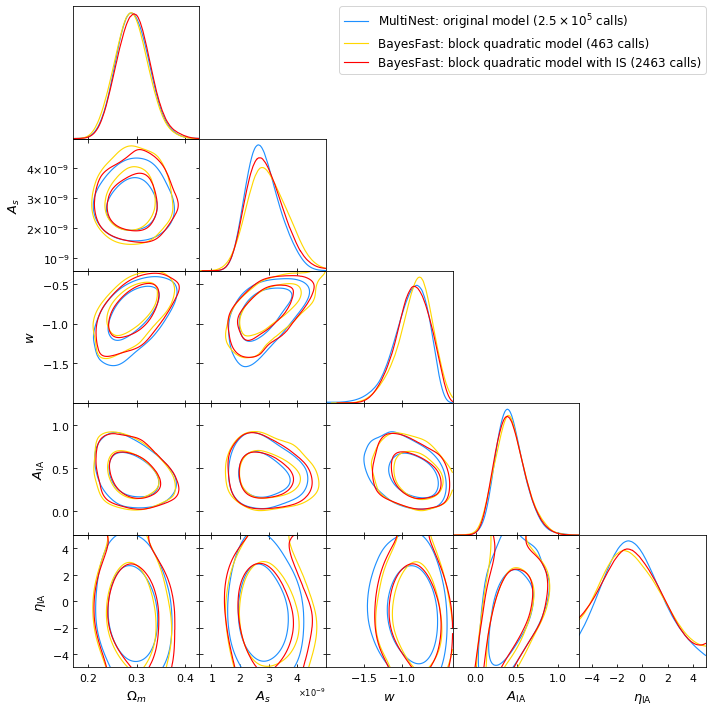

In [15]:
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
names = ["x%s"%i for i in range(5)]
labels =  ['\\Omega_m', 'A_s', 'w', 'A_{\\rm IA}', '\\eta_{\\rm IA}']
s_bf = MCSamples(
    samples=r_0.get().samples[:, _constrained_indices], names=names, 
    labels=labels, ranges=dict(zip(names, para_range[_constrained_indices])), 
    label='BayesFast: block quadratic model (463 calls)')
s_mn = MCSamples(
    samples=_x_mn[:, _constrained_indices], weights=_p_mn, names=names, 
    labels=labels, ranges=dict(zip(names, para_range[_constrained_indices])), 
    label='MultiNest: original model ($2.5\\times10^5$ calls)')
s_bf_i = MCSamples(
    samples=r_0.get().samples[:, _constrained_indices],
    weights=r_0.get().weights, names=names, 
    labels=labels, ranges=dict(zip(names, para_range[_constrained_indices])), 
    label='BayesFast: block quadratic model with IS (2463 calls)')
g = plots.getSubplotPlotter()
g.settings.figure_legend_loc = 'upper right'
g.settings.axes_fontsize = 14
g.settings.lab_fontsize = 16
g.settings.legend_fontsize = 15
g.settings.lw_contour = 2
g.settings.lw1 = 2
g.triangle_plot([s_mn, s_bf, s_bf_i], filled=False, contour_args={'alpha':1}, 
                diag1d_kwargs={'normalized':True}, contour_colors=['dodgerblue', 
                'gold', 'red'])#, contour_ls=['dashed', 'dotted', 'solid'])
plt.show()